In [186]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import seaborn as sns

## Analyzing the Impact of Female Directors and Writers

To answer what impact female directors and writers have we will take our director data from WikiData and supplemented CMU movie data to see underlying trends that may be present as well as understanding the impact of female writers and directors on a movie's IMDB rating.

### Contents
- [Merging and Cleaning](#merging_and_cleaning)
- [Analysis](#analysis)
    - [General Analysis](#general-analysis)
    - [Overall Difference Between Genders](#gender-diff)
    - [Director and Writer Breakdown per Movie](#director-writer-break)
    - [Genre Analysis](#genre)
    - [Directors and Writers in the Top 1000 Movies](#top-100)



### Merging and Cleaning <a id='Merging_and_cleaning'></a>
First we will merge our two relevent datasets together.

In [187]:
movies_full = pd.read_pickle('./data/pickles/movies.p')
directors_full = pd.read_pickle('./data/pickles/director_writer_nodrop.p')

print(movies_full.columns)
print(directors_full.columns)

Index(['title', 'primaryTitle', 'originalTitle', 'wikipedia_id',
       'freebase_id_cmu', 'wikidata_id', 'IMDB_id', 'mojo_id',
       'release_year_cmu', 'release_year_wd', 'release_year_imdb',
       'combined_release_year', 'runtime_cmu', 'runtime_wd', 'runtime_imdb',
       'combined_runtime', 'box_office_cmu', 'box_office_wd',
       'box_office_mojo', 'combined_box_office', 'languages', 'countries',
       'averageRating_imdb', 'numVotes_imdb', 'genres_cmu', 'genres_imdb',
       'directors', 'writers'],
      dtype='object')
Index(['title', 'movie_wiki_id', 'movie_wikidata_id', 'movie_freebase_id',
       'movie_imdb_id', 'role', 'imdb_id', 'wikidata_id', 'name', 'gender',
       'birth', 'height', 'ethnicity'],
      dtype='object')


There are many columns that are not relevant to the analysis to be done and therefore we will create a new DataFrame for both the movies and directors that have the columns to be analyzed.

In [188]:
movies = movies_full[[
    'title',
    'freebase_id_cmu',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu'
]].copy()

print(f'The length of the dataset is {len(movies)}, the number of freebase IDs is {len(movies.freebase_id_cmu.notna())}')
movies.genres_cmu = movies.genres_cmu.apply(lambda x: eval(x))
movies.head()

The length of the dataset is 81741, the number of freebase IDs is 81741


,title,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu
0,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'}


In [189]:
directors = directors_full[[
    'title',
    'movie_freebase_id',
    'movie_imdb_id',
    'role',
    'name',
    'imdb_id',
    'wikidata_id',
    'gender',
    'birth',
    'height',
    'ethnicity'
]]
directors.head()

,title,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height,ethnicity
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN,NaN
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN,NaN
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN,NaN


The data will be merged on the movie freebase ID

In [190]:
directors_movies_merge = pd.merge(left=directors, right=movies, how='left', 
                                    left_on='movie_freebase_id', right_on='freebase_id_cmu')

directors_movies_merge.head()

,title_x,movie_freebase_id,movie_imdb_id,role,name,imdb_id,wikidata_id,gender,birth,height,ethnicity,title_y,freebase_id_cmu,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu
0,Ghosts of Mars,/m/03vyhn,tt0228333,director,John Carpenter,nm0000118,Q95008,male,1948-01-16,NaN,NaN,Ghosts of Mars,/m/03vyhn,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,tt0245916,director,NaN,nm1740285,NaN,NaN,NaN,NaN,NaN,Getting Away with Murder: The JonBenét Ramsey ...,/m/08yl5d,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,Brun bitter,/m/0crgdbh,tt0094806,director,Sølve Skagen,nm0803751,Q7666470,male,1945-02-17,NaN,NaN,Brun bitter,/m/0crgdbh,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,White Of The Eye,/m/0285_cd,tt0094320,director,Donald Cammell,nm0131910,Q975488,male,1934-01-17,NaN,NaN,White Of The Eye,/m/0285_cd,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,A Woman in Flames,/m/01mrr1,tt0083949,director,Robert van Ackeren,nm0885554,Q88104,male,1946-12-22,NaN,NaN,A Woman in Flames,/m/01mrr1,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'}


After merging the dataset will need some cleaning before it can be analyzed.

In [191]:
print(all(directors_movies_merge.title_x == directors_movies_merge.title_y)) #are title_x and title_y are exactly the same?
directors_movies = directors_movies_merge[[
    'title_x',
    'combined_release_year',
    'combined_runtime',
    'averageRating_imdb',
    'numVotes_imdb',
    'genres_cmu',
    'movie_freebase_id',
    'movie_imdb_id',
    'imdb_id',
    'role',
    'name',
    'gender',
    'birth',
    'height',
    'ethnicity'
]].copy()

directors_movies.head()

True


,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN


The birth dates are stored as strings. For our analysis we will be using the birth year to obtain an "age at movie release" column so that we can also see how the success of directors and writers may change over their career.

In [192]:
directors_movies['birth_year'] = directors_movies.birth.apply(lambda x: int(x.split('-')[0]) if isinstance(x,str) else x)
directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0


In [193]:
print(f'There are {len(directors_movies[directors_movies.combined_release_year.isna()])} NaN values in the combined release year column')
print(f'There are {len(directors_movies[directors_movies.birth_year.isna()])} NaN values in the birth year column')

There are 2 NaN values in the combined release year column
There are 93750 NaN values in the birth year column


In [194]:
#create a column to store age at release values
directors_movies['age_at_release'] = np.nan

#fill in with actual values of age at release year if there is both a release year and a birth year
for indx, row in directors_movies.loc[directors_movies.combined_release_year.notna() & directors_movies.birth_year.notna()].iterrows():
    directors_movies.loc[indx,'age_at_release'] = row.combined_release_year- row.birth_year

directors_movies.head()

,title_x,combined_release_year,combined_runtime,averageRating_imdb,numVotes_imdb,genres_cmu,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,{'/m/07s9rl0': 'Drama'},/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0,37.0


The genre data is currently stored as a dictionary with the the freebase ID as the key and the genre as the value. Let's change this to just a list of genres per movie.

In [195]:
print(f'There are {len(directors_movies[directors_movies.genres_cmu.isna()])} NaN values in the genres_cmu column')

There are 0 NaN values in the genres_cmu column


In [196]:
directors_movies.genres_cmu = directors_movies.genres_cmu.apply(lambda x: list(x.values()))

Lastly for the ease of analysis some of the column names will be changed/shortened.

In [197]:
directors_movies.rename(mapper={
    'title_x': 'title',
    'combined_runtime':'runtime',
    'combined_release_year':'release_year',
    'averageRating_imdb':'rating',
    'genres_cmu':'genres',
    'numVotes_imdb':'num_votes'    
},inplace=True, axis=1)
directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,name,gender,birth,height,ethnicity,birth_year,age_at_release
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn,tt0228333,nm0000118,director,John Carpenter,male,1948-01-16,NaN,NaN,1948.0,53.0
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"[Mystery, Biographical film, Drama, Crime Drama]",/m/08yl5d,tt0245916,nm1740285,director,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brun bitter,1988.0,83.0,5.7,40.0,"[Crime Fiction, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,Sølve Skagen,male,1945-02-17,NaN,NaN,1945.0,43.0
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd,tt0094320,nm0131910,director,Donald Cammell,male,1934-01-17,NaN,NaN,1934.0,53.0
4,A Woman in Flames,1983.0,106.0,6.0,587.0,[Drama],/m/01mrr1,tt0083949,nm0885554,director,Robert van Ackeren,male,1946-12-22,NaN,NaN,1946.0,37.0


In [198]:
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,250743.000000,238079.000000,234845.000000,2.348450e+05,156995.000000,156994.000000
mean,1975.509402,94.538418,6.300630,1.263893e+04,1928.575878,44.171140
std,28.481179,90.933387,1.149018,6.790405e+04,30.220792,15.249931
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,-48.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1981.000000,93.000000,6.400000,5.870000e+02,1929.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,51.000000
max,2023.000000,14400.000000,10.000000,2.648879e+06,2005.000000,1999.000000


Looks like we need to do a little bit of cleaning on the age_at_release column. The assumption is being made that children are not able to work as directors or writers and we will remove age at release values that are less than 18 and the oldest acting film director was Manoel de Oliveira who worked until he was approximately 99. In general we can assume that values this high could be outliers

In [199]:
directors_movies.age_at_release=directors_movies.age_at_release.apply(lambda x: np.nan if x<18 else (np.nan if x> 99 else x))
directors_movies.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release
count,250743.000000,238079.000000,234845.000000,2.348450e+05,156995.000000,153661.000000
mean,1975.509402,94.538418,6.300630,1.263893e+04,1928.575878,43.988006
std,28.481179,90.933387,1.149018,6.790405e+04,30.220792,11.642809
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000
25%,1953.000000,80.000000,5.700000,1.360000e+02,1904.000000,36.000000
50%,1981.000000,93.000000,6.400000,5.870000e+02,1929.000000,42.000000
75%,2002.000000,107.000000,7.100000,2.745000e+03,1953.000000,50.000000
max,2023.000000,14400.000000,10.000000,2.648879e+06,2005.000000,99.000000


Now that we have a new metric we can add that in here so that it can propagate throughout the rest of the DataFrames referenced later on in the notebook

In [200]:
mean_ratings = directors_movies.rating.mean()
std_ratings = directors_movies.rating.std()
directors_movies['normal_rating'] = (directors_movies.rating-mean_ratings)/std_ratings
directors_movies['abs_normal_rating'] = abs(directors_movies.normal_rating)

directors_movies['log_num_votes'] = np.log(directors_movies.num_votes)
mean_log_votes = directors_movies.log_num_votes.mean()
std_log_votes = directors_movies.log_num_votes.std()
directors_movies['normal_log_num_votes'] = (directors_movies.log_num_votes - mean_log_votes)/std_log_votes
min_norm_log_num_votes = directors_movies.normal_log_num_votes.min()

directors_movies['impact_score'] = (directors_movies.normal_log_num_votes) * directors_movies.abs_normal_rating
directors_movies['impact_score_2'] = (directors_movies.normal_log_num_votes-min_norm_log_num_votes) * directors_movies.normal_rating

directors_movies.head()

,title,release_year,runtime,rating,num_votes,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,...,height,ethnicity,birth_year,age_at_release,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn,tt0228333,nm0000118,director,...,NaN,NaN,1948.0,53.0,-1.218980,1.218980,10.916197,1.928541,2.350853,-4.981245
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"[Mystery, Biographical film, Drama, Crime Drama]",/m/08yl5d,tt0245916,nm1740285,director,...,NaN,NaN,NaN,NaN,-0.348672,0.348672,4.189655,-1.024943,-0.357369,-0.395017
2,Brun bitter,1988.0,83.0,5.7,40.0,"[Crime Fiction, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,...,NaN,NaN,1945.0,43.0,-0.522734,0.522734,3.688879,-1.244823,-0.650711,-0.477276
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd,tt0094320,nm0131910,director,...,NaN,NaN,1934.0,53.0,-0.174610,0.174610,7.838738,0.577293,0.100801,-0.477586
4,A Woman in Flames,1983.0,106.0,6.0,587.0,[Drama],/m/01mrr1,tt0083949,nm0885554,director,...,NaN,NaN,1946.0,37.0,-0.261641,0.261641,6.375025,-0.065393,-0.017109,-0.547476


In [201]:
directors_movies['genre_1'] =  directors_movies.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)

### Analysis <a id='analysis'></a>


#### General Analysis <a id='general_analysis'></a>

Before getting too deep into the analysis it should be understood what is in the data and what is missing from the data.

 We can first understand what director data was able to be collected. how many movies have complete director and writer data, how many movies have at least one director or writer present and how many directors and writers are present for each gender.

In [202]:
dirs = directors_movies[directors_movies.role == 'director']
writers = directors_movies[directors_movies.role == 'writer']
dir_num_tot = dirs.imdb_id.nunique()
wri_num_tot = writers.imdb_id.nunique()
uniq_dirs = dirs.drop_duplicates(subset='imdb_id', keep='first')
uniq_wris = writers.drop_duplicates(subset='imdb_id', keep='first')
full_dirs = uniq_dirs.dropna(subset=['gender', 'name', 'birth'])
full_wris = uniq_wris.dropna(subset=['gender', 'name', 'birth'])

print(f'Out of {len(directors_movies)} rows of data:')
print(f'There are {len(dirs)} number of directors and {len(writers)} number of writers.')
print(f'There are {dir_num_tot} number of unique directors and {wri_num_tot} number of unique writers.')
print(f'\nOut of all of the unique directors {len(uniq_dirs[uniq_dirs.name.notna()])} have a name, {len(uniq_dirs[uniq_dirs.gender.notna()])} have a gender, {len(uniq_dirs[uniq_dirs.height.notna()])} have a height, {len(uniq_dirs[uniq_dirs.ethnicity.notna()])} have an ethnicity, and {len(uniq_dirs[uniq_dirs.birth_year.notna()])} have a birth year.')
print(f'\nOut of all of the unique writers {len(uniq_wris[uniq_wris.name.notna()])} have a name, {len(uniq_wris[uniq_wris.gender.notna()])} have a gender, {len(uniq_wris[uniq_wris.height.notna()])} have a height, {len(uniq_wris[uniq_wris.ethnicity.notna()])} have an ethnicity, and {len(uniq_wris[uniq_wris.birth_year.notna()])} have a birth year.')
print(f'\nFor this analysis height and ethinicity will not be considered due to lack of complete data')
print(f'Out of all of the directors there are {len(full_dirs)} with complete gender, name, and birth data')
print(f'Out of all of the writers there are {len(full_wris)} with complete gender, name, and birth data')

Out of 250745 rows of data:
There are 86474 number of directors and 164271 number of writers.
There are 29028 number of unique directors and 60785 number of unique writers.

Out of all of the unique directors 21204 have a name, 18743 have a gender, 130 have a height, 91 have an ethnicity, and 16783 have a birth year.

Out of all of the unique writers 25969 have a name, 24298 have a gender, 171 have a height, 143 have an ethnicity, and 22087 have a birth year.

For this analysis height and ethinicity will not be considered due to lack of complete data
Out of all of the directors there are 16654 with complete gender, name, and birth data
Out of all of the writers there are 21997 with complete gender, name, and birth data


Let's see how many movies are present that have a complete set of directors and writers that have at least gender information

In [203]:
movie_groups = directors_movies.groupby('movie_freebase_id')

for fb_id, movie in tqdm(movie_groups):
    all_data = True
    indices = []
    for indx, row in movie.iterrows():
        indices.append(indx)
        if row.gender != 'male' and row.gender!= 'female':
            all_data = False
    directors_movies.loc[indices,'all_crew'] = all_data
    

100%|██████████| 74200/74200 [00:46<00:00, 1583.00it/s]


In [204]:
full_crew = directors_movies[directors_movies.all_crew == True]
print(f'Out of {directors_movies.movie_freebase_id.nunique()}, there are {directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()} movies that have at least one director or writer with gender data')
print(f'and there are {full_crew.movie_freebase_id.nunique()} movies with full crew gender data.')
print(f'This is means that {round(directors_movies[directors_movies.gender.notna()].movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)*100}% have at least one point of gender data and {100*round(full_crew.movie_freebase_id.nunique()/directors_movies.movie_freebase_id.nunique(),4)}% of the movies have full crew gender data.')

Out of 74200, there are 66755 movies that have at least one director or writer with gender data
and there are 27382 movies with full crew gender data.
This is means that 89.97% have at least one point of gender data and 36.9% of the movies have full crew gender data.


It would also be interesting to see how many people there is at least gender data for that have worked as both directors and writers.

In [205]:
both_dir_writer = directors_movies.dropna(subset='gender').groupby('imdb_id').role.nunique()
print(f'There are {len(both_dir_writer[both_dir_writer>1])} number of people who have gender data that have worked as both a director and writer.')

There are 12691 number of people who have gender data that have worked as both a director and writer.


From the above analysis we can see that in general there is a lot of data available for analysis on gender and still a significant portion of data available with gender data on the full crew. There is also more complete data on a larger percentage of the directors than for the writers and there are many people who work as both a writer and a director.

Now that we have an understanding of the number of data points that are present. the data can start to be analyzed for trends. To start the data set can be split into male writers/directors and female writers/directors and analyzed.



#### Overall Differnce Between Genders <a id='gender-diff'></a>

The data can be divided by role and gender to start an exploratory analysis into what trends may exist within the data.

In [206]:
male_dir = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'director')]
male_writer = directors_movies.loc[(directors_movies.gender == 'male') & (directors_movies.role == 'writer')]
female_dir = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'director')]
female_writer = directors_movies.loc[(directors_movies.gender == 'female') & (directors_movies.role == 'writer')]

male_dir.describe()


,release_year,runtime,rating,num_votes,birth_year,age_at_release,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2
count,66630.000000,63114.000000,61922.000000,6.192200e+04,63267.000000,62171.000000,61922.000000,61922.000000,61922.000000,61922.000000,61922.000000,61922.000000
mean,1973.837175,93.060367,6.319620,1.235680e+04,1928.950132,43.857361,0.016527,0.753781,6.534994,0.004846,0.028135,0.173738
std,29.008938,69.186642,1.120251,6.527563e+04,30.636233,10.806952,0.974964,0.618573,2.277638,1.000063,1.005454,2.359717
min,1878.000000,0.000000,1.000000,5.000000e+00,1.000000,18.000000,-4.613183,0.000548,1.609438,-2.157863,-8.357554,-17.302810
25%,1951.000000,78.000000,5.700000,1.370000e+02,1904.000000,36.000000,-0.522734,0.261641,4.919981,-0.704272,-0.332238,-0.870395
50%,1979.000000,93.000000,6.400000,5.920000e+02,1930.000000,43.000000,0.086482,0.609764,6.383507,-0.061669,-0.004498,0.189448
75%,2001.000000,107.000000,7.100000,2.774750e+03,1954.000000,50.000000,0.695698,1.043822,7.928316,0.616625,0.326508,1.329045
max,2023.000000,9360.000000,9.700000,2.648879e+06,2005.000000,99.000000,2.958500,4.613183,14.789647,3.629292,9.473819,15.106654


In [207]:
female_dir.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2
count,3650.000000,3499.000000,3541.000000,3541.000000,3271.000000,3105.000000,3541.000000,3541.000000,3541.000000,3541.000000,3541.000000,3541.000000
mean,1995.218082,91.058874,6.520418,8019.574979,1951.999389,42.987762,0.191283,0.750222,6.533098,0.004013,-0.006736,0.435999
std,18.255445,36.113077,1.062280,36854.270301,23.148688,11.062025,0.924511,0.572999,2.147250,0.942813,0.915530,2.158077
min,1896.000000,1.000000,1.600000,5.000000,1872.000000,18.000000,-4.090998,0.000548,1.609438,-2.157863,-7.582732,-11.743841
25%,1990.000000,81.000000,5.900000,155.000000,1945.000000,35.000000,-0.348672,0.261641,5.043425,-0.650071,-0.339995,-0.568682
50%,2001.000000,93.000000,6.600000,595.000000,1956.000000,42.000000,0.260544,0.609764,6.388561,-0.059449,-0.016601,0.496825
75%,2007.000000,105.000000,7.200000,2662.000000,1967.000000,50.000000,0.782729,1.044919,7.886833,0.598410,0.276779,1.564786
max,2019.000000,763.000000,9.400000,842297.000000,2000.000000,99.000000,2.697408,4.090998,13.643888,3.126213,6.156391,10.474621


In [208]:
male_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2
count,85814.000000,83436.000000,81806.000000,8.180600e+04,81525.000000,79735.000000,81806.000000,81806.000000,81806.000000,81806.000000,81806.000000,81806.000000
mean,1972.954087,95.777374,6.343832,1.764436e+04,1927.181711,44.213495,0.037599,0.717572,6.837224,0.137549,0.145676,0.258782
std,27.589316,46.672009,1.068824,8.192645e+04,29.530843,12.201127,0.930207,0.593113,2.359233,1.035890,1.014649,2.415304
min,1894.000000,0.000000,1.000000,5.000000e+00,1622.000000,18.000000,-4.613183,0.000548,1.609438,-2.157863,-8.357554,-16.507666
25%,1951.000000,82.000000,5.800000,1.750000e+02,1904.000000,36.000000,-0.435703,0.261641,5.164786,-0.596784,-0.240899,-0.811143
50%,1975.000000,94.000000,6.500000,7.760000e+02,1926.000000,42.000000,0.173513,0.608667,6.654153,0.057166,0.004028,0.233388
75%,1999.000000,108.000000,7.100000,3.892750e+03,1952.000000,51.000000,0.695698,0.957888,8.266871,0.765277,0.425430,1.404921
max,2023.000000,4875.000000,9.500000,2.648879e+06,2005.000000,99.000000,2.784439,4.613183,14.789647,3.629292,9.473819,15.106654


In [209]:
female_writer.describe()

,release_year,runtime,rating,num_votes,birth_year,age_at_release,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2
count,9269.000000,9070.000000,8775.000000,8.775000e+03,8482.000000,8204.000000,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000,8775.000000
mean,1975.256662,93.644432,6.383442,1.426396e+04,1929.538081,43.340931,0.072071,0.655316,6.886669,0.159259,0.145147,0.306257
std,30.896842,34.041105,0.982049,7.095991e+04,32.235211,12.403254,0.854686,0.553348,2.208298,0.969618,0.939202,2.222090
min,1896.000000,1.000000,1.000000,5.000000e+00,1855.000000,18.000000,-4.613183,0.000548,1.609438,-2.157863,-8.181308,-15.044068
25%,1946.000000,80.000000,5.900000,2.200000e+02,1899.000000,35.000000,-0.348672,0.260544,5.393628,-0.496304,-0.185105,-0.673074
50%,1986.000000,93.000000,6.500000,8.220000e+02,1932.000000,41.000000,0.173513,0.521637,6.711740,0.082452,0.009978,0.295878
75%,2004.000000,106.000000,7.000000,3.819000e+03,1958.000000,50.000000,0.608667,0.956791,8.247743,0.756878,0.377798,1.355348
max,2022.000000,822.000000,9.400000,1.851387e+06,2000.000000,99.000000,2.697408,4.613183,14.431446,3.472013,8.141760,13.211193


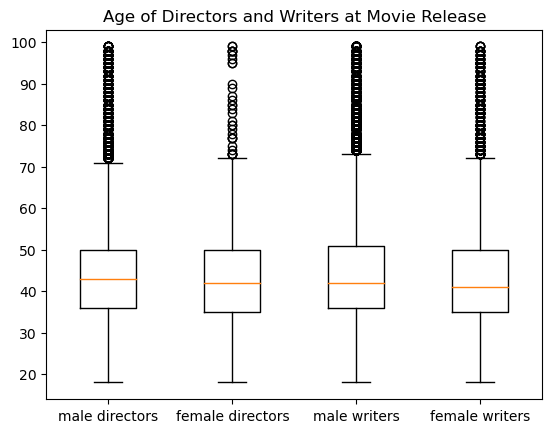

In [210]:

plt.boxplot([male_dir.age_at_release.dropna(), 
    female_dir.age_at_release.dropna(), 
    male_writer.age_at_release.dropna(), 
    female_writer.age_at_release.dropna()],
    showfliers=None,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Age of Directors and Writers at Movie Release')
None


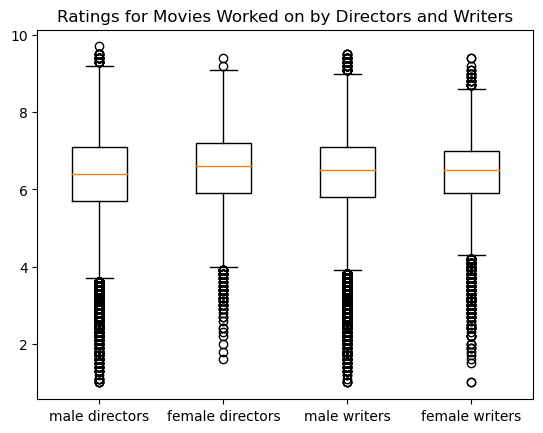

In [211]:
plt.boxplot([male_dir.rating.dropna(), 
    female_dir.rating.dropna(), 
    male_writer.rating.dropna(), 
    female_writer.rating.dropna()],
    showfliers=None,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Ratings for Movies Worked on by Directors and Writers')
None

Outliers were taken out for this analysis because they do not allow for the box plots to be visible


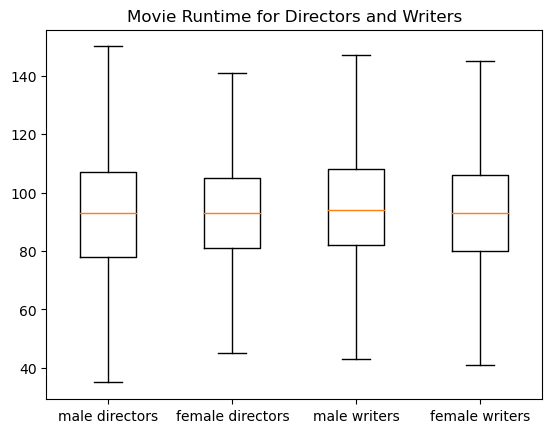

In [212]:
plt.boxplot([male_dir.runtime.dropna(), 
    female_dir.runtime.dropna(), 
    male_writer.runtime.dropna(), 
    female_writer.runtime.dropna()],
    showfliers=False,
    labels=['male directors', 'female directors', 'male writers', 'female writers']
)
plt.title('Movie Runtime for Directors and Writers')
print('Outliers were taken out for this analysis because they do not allow for the box plots to be visible')

In [213]:
print('there were a lot of outliers here so the data was presented as text instead of plots.')
print(f'The median number of votes for male directors is {male_dir.num_votes.median()}, the mean is {male_dir.num_votes.mean()}, and the standard deviation is {male_dir.num_votes.std()}\n')
print(f'The median number of votes for female directors is {female_dir.num_votes.median()}, the mean is {female_dir.num_votes.mean()}, and the standard deviation is {female_dir.num_votes.std()}\n')
print(f'The median number of votes for male writers is {male_writer.num_votes.median()}, the mean is {male_writer.num_votes.mean()}, and the standard deviation is {male_writer.num_votes.std()}\n')
print(f'The median number of votes for female writers is {female_writer.num_votes.median()}, the mean is {female_writer.num_votes.mean()}, and the standard deviation is {female_writer.num_votes.std()}\n')

there were a lot of outliers here so the data was presented as text instead of plots.
The median number of votes for male directors is 592.0, the mean is 12356.796372856174, and the standard deviation is 65275.63145571934

The median number of votes for female directors is 595.0, the mean is 8019.574978819543, and the standard deviation is 36854.270301136006

The median number of votes for male writers is 776.0, the mean is 17644.36145270518, and the standard deviation is 81926.44802483442

The median number of votes for female writers is 822.0, the mean is 14263.96376068376, and the standard deviation is 70959.91130053245



From the above plot it can be seen that in general the age range for directors and writers at movie release, movie ratings, and movie runtime is consistent between men and women. The data for number of votes contains large descrepancies and is dificult to analyze on the service, but it can be seen that the standard deviation for each group is very large compared to the mean and median.

Text(37.597222222222214, 0.5, 'male director age')

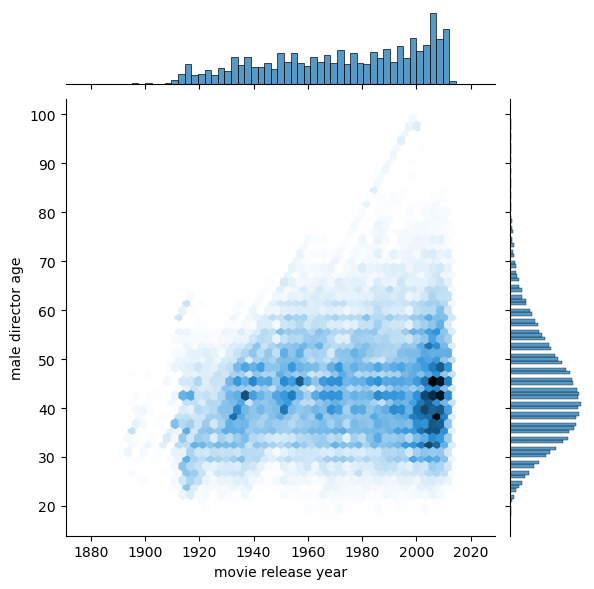

In [214]:
sns.jointplot(x='release_year', y='age_at_release', data=male_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male director age')

Text(37.597222222222214, 0.5, 'female director age')

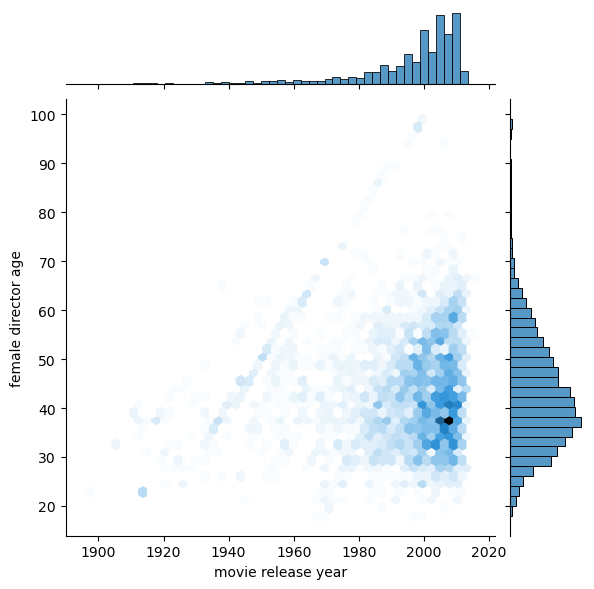

In [215]:
sns.jointplot(x='release_year', y='age_at_release', data=female_dir, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female director age')

Text(37.597222222222214, 0.5, 'male writer age')

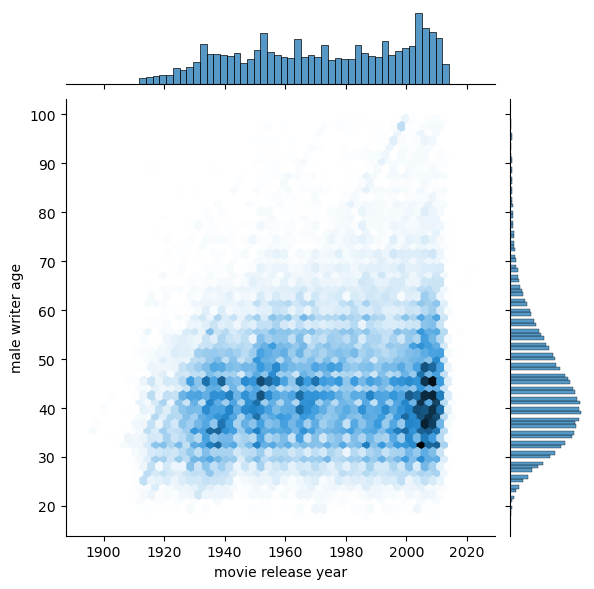

In [216]:
sns.jointplot(x='release_year', y='age_at_release', data=male_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('male writer age')

Text(37.597222222222214, 0.5, 'female writer age')

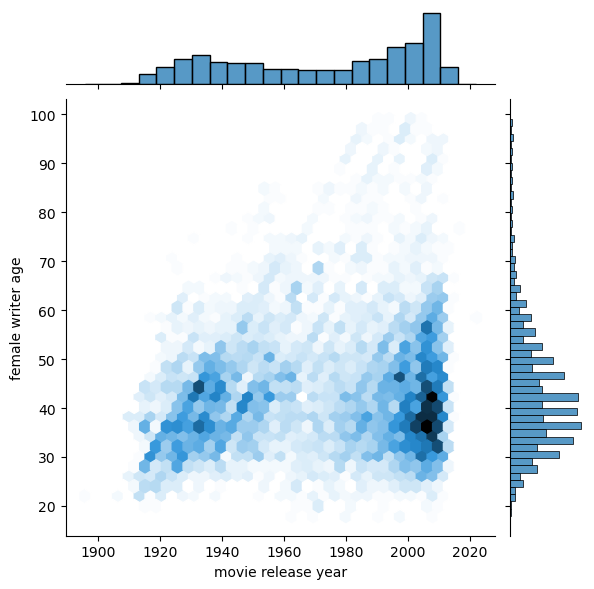

In [217]:
sns.jointplot(x='release_year', y='age_at_release', data=female_writer, kind='hex')
plt.xlabel('movie release year')
plt.ylabel('female writer age')

From the above graphs we can see that in general the age of  male writers and directors has been fairly consistent throughout the time period in the CMU dataset, but it can be seen that there is a large increase in the amount of female directors past 1980 and a bimodal distribution of female writers.

Next the number of directors and writers will be analyzed.

Text(0.5, 0, 'female writers')

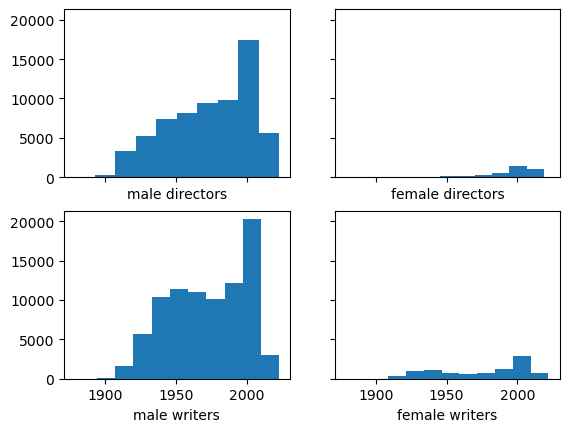

In [218]:
fig, ax = plt.subplots(2,2, sharex= True, sharey= True)
ax[0,0].hist(male_dir.release_year)
ax[0,1].hist(female_dir.release_year)
ax[1,0].hist(male_writer.release_year)
ax[1,1].hist(female_writer.release_year)
ax[0,0].set_xlabel('male directors')
ax[0,1].set_xlabel('female directors')
ax[1,0].set_xlabel('male writers')
ax[1,1].set_xlabel('female writers')


From the above histrograms it can be seen that the number of female directors and writers that took part in movies compared to male directors and writers.

Text(0.5, 0, 'movie release year')

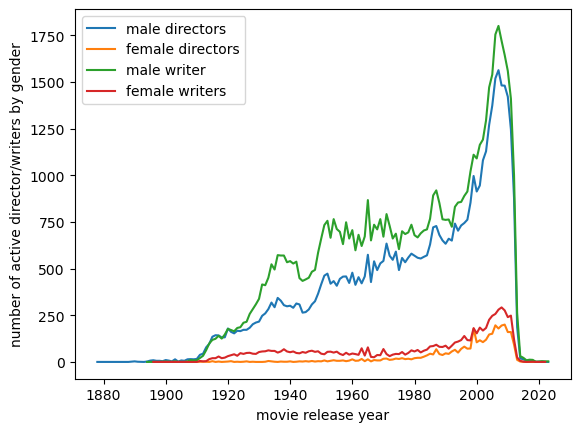

In [219]:
year_num_male_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_male_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'male')].groupby('release_year').imdb_id.nunique()
year_num_female_dir = directors_movies.loc[(directors_movies.role == 'director')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()
year_num_female_wri = directors_movies.loc[(directors_movies.role == 'writer')&(directors_movies.gender == 'female')].groupby('release_year').imdb_id.nunique()

plt.plot(year_num_male_dir, label='male directors')
plt.plot(year_num_female_dir, label='female directors')
plt.plot(year_num_male_wri, label='male writer')
plt.plot(year_num_female_wri, label='female writers')
plt.legend()
plt.ylabel('number of active director/writers by gender')
plt.xlabel('movie release year')


From the above inital analysis it can be seen that the age at release and movie ratings for male and female movie directors and writes are very similar although the number of males to females in the movie industry behind the behind is siginificantly different with their being much less female directors and writers.


#### Director and Writer Breakdown per Movie <a id='director-writer-break'></a>

Now that trends at large have been analyzed the effect of female team members for individual movies can be looked into. 

For this analysis the data used will only include movies that have complete team member data. First does having more women on a movie's creative team lead to a higher IMDB rating?

In [220]:
rating_by_fperc = pd.DataFrame()
rating_by_fperc['percent_female'] = full_crew.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

rating_by_fperc['rating'] = full_crew.groupby('movie_freebase_id').rating.unique()
print(f'Is there only one unique rating value per movie? {all(rating_by_fperc.rating.apply(lambda x: len(x)) == 1)}')
rating_by_fperc['rating'] = rating_by_fperc['rating'].apply(lambda x: x[0])
rating_by_fperc['release_year'] = full_crew.groupby('release_year').rating.unique()
rating_by_fperc.head()

Is there only one unique rating value per movie? True


,percent_female,rating,release_year
movie_freebase_id,,,
/m/011_mj,0.0,8.1,NaN
/m/011x_4,0.0,8.1,NaN
/m/011xg5,0.0,7.2,NaN
/m/011xrr,0.0,6.2,NaN
/m/011ycb,0.0,7.5,NaN


Text(0.5, 0, 'Percentage of Females on Writing Team')

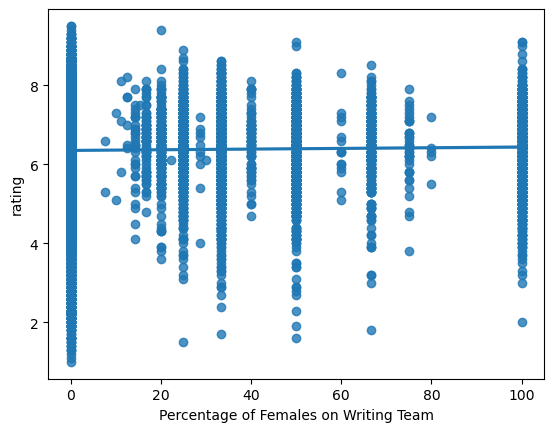

In [221]:
sns.regplot(data=rating_by_fperc, x='percent_female', y='rating')
plt.xlabel('Percentage of Females on Writing Team')

Text(0.5, 1.0, 'Average Movie Ratings Compared to Percent of Females on Creative Team')

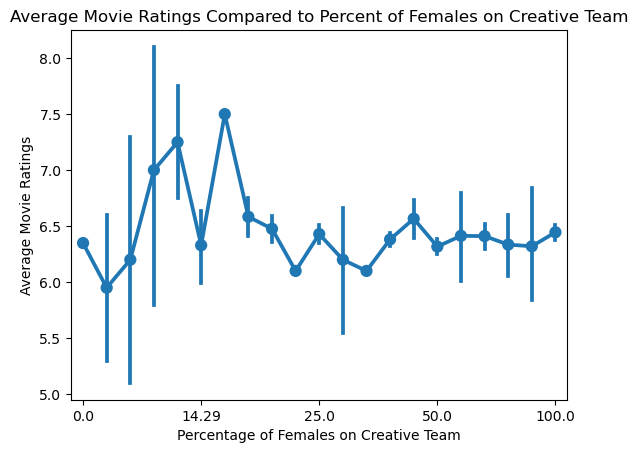

In [222]:
data_length = len(rating_by_fperc)
sns.pointplot(data=rating_by_fperc, x='percent_female', y='rating', errorbar=('ci', 95))
plt.xticks([0,5,10,15, 20])
plt.xlabel('Percentage of Females on Creative Team')
plt.ylabel('Average Movie Ratings')
plt.title('Average Movie Ratings Compared to Percent of Females on Creative Team')


In [223]:
year_by_fperc = pd.DataFrame()
year_by_fperc = pd.merge(left=rating_by_fperc, right=full_crew[['release_year', 'movie_freebase_id']], how='left', left_on=rating_by_fperc.index, right_on='movie_freebase_id' )
year_by_fperc.drop('release_year_x', inplace=True, axis=1)
year_by_fperc.rename(mapper = {'release_year_y':'release_year'}, axis=1, inplace=True)
year_by_fperc.head()

,percent_female,rating,release_year,movie_freebase_id
0,0.0,8.1,1928.0,/m/011_mj
1,0.0,8.1,1928.0,/m/011_mj
2,0.0,8.1,1993.0,/m/011x_4
3,0.0,8.1,1993.0,/m/011x_4
4,0.0,8.1,1993.0,/m/011x_4


In [224]:
year_by_fperc_avg=pd.DataFrame()
year_by_fperc_avg['percent_female_avg'] = year_by_fperc.groupby('release_year').percent_female.mean()
year_by_fperc_avg['rating_avg'] = year_by_fperc.groupby('release_year').rating.mean()
year_by_fperc_avg['number_of_titles'] = year_by_fperc.groupby('release_year').movie_freebase_id.count()
print(year_by_fperc_avg.describe())
#get rid of years that only have a few data points
old_num_titles = year_by_fperc_avg.number_of_titles.sum()
year_by_fperc_avg = year_by_fperc_avg[year_by_fperc_avg.number_of_titles>50]
new_num_titles = year_by_fperc_avg.number_of_titles.sum()

print(f'There were a total of {old_num_titles-new_num_titles} titles removed from the list')
print(f'This represented {round((old_num_titles-new_num_titles)/old_num_titles,4)*100}% of the data')


       percent_female_avg  rating_avg  number_of_titles
count          124.000000  122.000000        124.000000
mean             6.726489    6.286537        603.112903
std              4.746564    0.352005        463.099652
min              0.000000    4.500000          2.000000
25%              3.671392    6.221604        292.000000
50%              6.055090    6.375528        626.000000
75%              9.317480    6.478089        774.500000
max             33.333333    7.100000       1957.000000
There were a total of 218 titles removed from the list
This represented 0.29% of the data


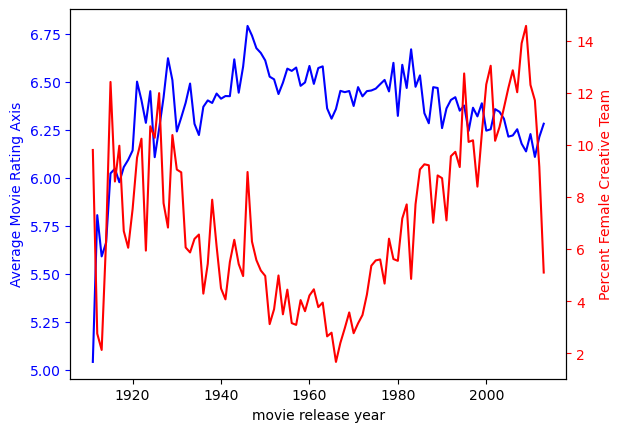

In [225]:
fig, ax = plt.subplots()

ax.plot(year_by_fperc_avg.index, year_by_fperc_avg.rating_avg, color='blue')
ax.set_ylabel('Average Movie Rating Axis', color="blue")        # set y axis title to blue
ax.tick_params(axis='y', colors="blue")       # set y axis tick labels to blue
ax.set_xlabel('movie release year')

ax2 = ax.twinx()
ax2.plot(year_by_fperc_avg.index, year_by_fperc_avg.percent_female_avg, color='red')
ax2.set_ylabel('Percent Female Creative Team', color="red")        # set y axis title to red
ax2.tick_params(axis='y', colors="red")       # set y axis tick labels to red


It can be seen that it is possible there is a inverse correlation between the average percent of women on a creative team and the average movie IMDB rating per year, but the impact does not look like its significant as the movie ratings stay within 0.5/10 from each other.


#### Genre Analysis <a id='genre'></a>

The last part of the data that will be explored is how female directors and writers are split amongst various genres of movies.

First let's understand what the most numerous genres are. The analysis will be carried out by keeping the first three genres with the assumption that the first genre present is the main genre.

In [226]:
genres_df = directors_movies.copy()
print(genres_df.columns)
print(f'There are {len(genres_df[genres_df.genres.isna()])} null values in the genres column')
print(f'There are {len(genres_df[genres_df.genres.apply(lambda x: len(x)) == 0])} empty lists in the genres column')
genres_df['genre_1'] = genres_df.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)
genres_df['genre_2'] = genres_df.genres.apply(lambda x: x[1] if len(x)>1 else np.nan)
genres_df['genre_3'] = genres_df.genres.apply(lambda x: x[2] if len(x)>2 else np.nan)

genres_df.head()

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres',
       'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role', 'name',
       'gender', 'birth', 'height', 'ethnicity', 'birth_year',
       'age_at_release', 'normal_rating', 'abs_normal_rating', 'log_num_votes',
       'normal_log_num_votes', 'impact_score', 'impact_score_2', 'genre_1',
       'all_crew'],
      dtype='object')
There are 0 null values in the genres column
There are 7864 empty lists in the genres column


,title,release_year,runtime,rating,num_votes,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,...,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2,genre_1,all_crew,genre_2,genre_3
0,Ghosts of Mars,2001.0,98.0,4.9,55061.0,"[Thriller, Science Fiction, Horror, Adventure,...",/m/03vyhn,tt0228333,nm0000118,director,...,-1.218980,1.218980,10.916197,1.928541,2.350853,-4.981245,Thriller,False,Science Fiction,Horror
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,5.9,66.0,"[Mystery, Biographical film, Drama, Crime Drama]",/m/08yl5d,tt0245916,nm1740285,director,...,-0.348672,0.348672,4.189655,-1.024943,-0.357369,-0.395017,Mystery,False,Biographical film,Drama
2,Brun bitter,1988.0,83.0,5.7,40.0,"[Crime Fiction, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,...,-0.522734,0.522734,3.688879,-1.244823,-0.650711,-0.477276,Crime Fiction,True,Drama,NaN
3,White Of The Eye,1987.0,110.0,6.1,2537.0,"[Thriller, Erotic thriller, Psychological thri...",/m/0285_cd,tt0094320,nm0131910,director,...,-0.174610,0.174610,7.838738,0.577293,0.100801,-0.477586,Thriller,False,Erotic thriller,Psychological thriller
4,A Woman in Flames,1983.0,106.0,6.0,587.0,[Drama],/m/01mrr1,tt0083949,nm0885554,director,...,-0.261641,0.261641,6.375025,-0.065393,-0.017109,-0.547476,Drama,False,NaN,NaN


The first analysis to be run will be to compare the statistics of the top 15 movie genres in regards to 

In [227]:
genres_group = pd.DataFrame()
genres_group['movie_count'] = genres_df.groupby('genre_1').movie_imdb_id.agg('count')
genres_group['imdb_rating'] = genres_df.groupby('genre_1').rating.agg('mean')
genres_group['male_dirs'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'director') & (x.gender == 'male')]))
genres_group['female_dirs'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'director') & (x.gender == 'female')]))
genres_group['male_wris'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'writer') & (x.gender == 'male')]))
genres_group['female_wris'] = genres_df.groupby('genre_1').apply(lambda x: len(x.loc[(x.role == 'writer') & (x.gender == 'female')]))
genres_group['fperc_dirs'] = genres_group.female_dirs/(genres_group.female_dirs+genres_group.male_dirs)*100
genres_group['fperc_wris'] = genres_group.female_wris/(genres_group.female_wris+genres_group.male_wris)*100
genres_group.sort_values('movie_count', inplace=True, ascending=False)

top_genres = genres_group.head(15).index
genres_group.head(15)


,movie_count,imdb_rating,male_dirs,female_dirs,male_wris,female_wris,fperc_dirs,fperc_wris
genre_1,,,,,,,,
Drama,36871,6.586367,9537,686,12718,1710,6.710359,11.851955
Thriller,22302,5.908169,6004,170,8570,649,2.753482,7.039809
Short Film,17067,6.623062,6083,234,4718,263,3.704290,5.280064
Crime Fiction,16917,6.238030,4587,136,6469,459,2.879526,6.625289
Romance Film,9894,6.235951,2492,110,3329,481,4.227517,12.624672
Comedy,9239,6.079877,2377,107,3872,258,4.307568,6.246973
Silent film,8585,6.199396,2611,29,2714,625,1.098485,18.718179
Comedy film,8192,6.064265,2033,66,3097,236,3.144354,7.080708
Romantic comedy,8158,6.141410,2019,221,3046,612,9.866071,16.730454


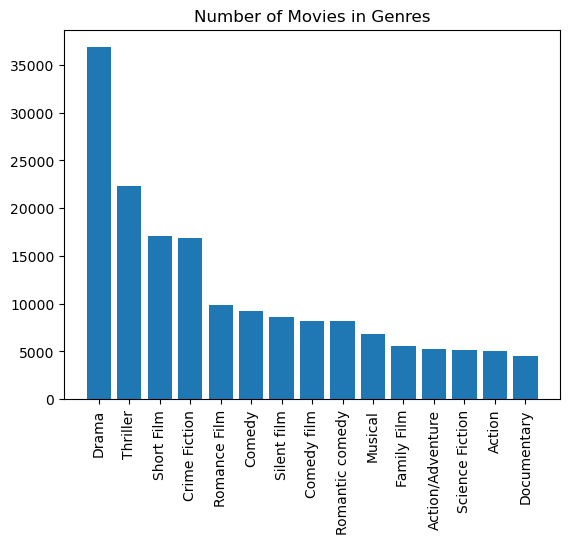

In [228]:
plt.bar(genres_group.head(15).index, genres_group.movie_count.head(15))
plt.xticks(rotation=90)
plt.title('Number of Movies in Genres')
None

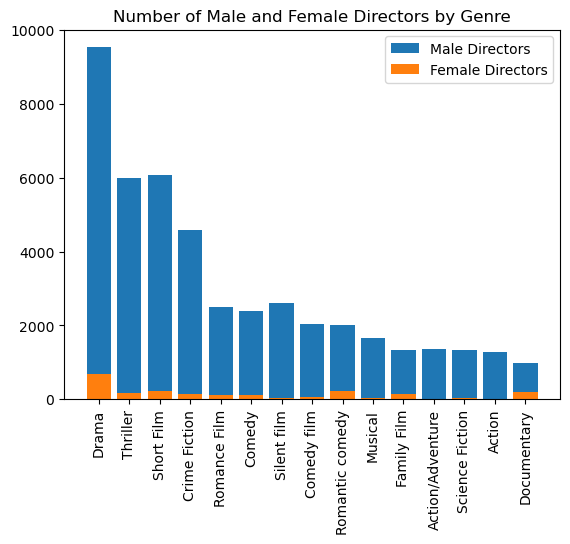

In [229]:
plt.bar(genres_group.head(15).index, genres_group.male_dirs.head(15), label='Male Directors')
plt.bar(genres_group.head(15).index, genres_group.female_dirs.head(15), label='Female Directors')
plt.xticks(rotation=90)
plt.title('Number of Male and Female Directors by Genre')
plt.legend()
None

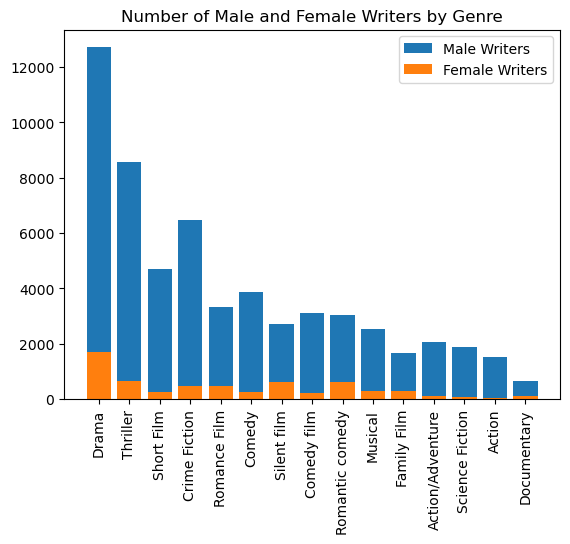

In [230]:
plt.bar(genres_group.head(15).index, genres_group.male_wris.head(15), label='Male Writers')
plt.bar(genres_group.head(15).index, genres_group.female_wris.head(15), label='Female Writers')
plt.xticks(rotation=90)
plt.title('Number of Male and Female Writers by Genre')
plt.legend()
None

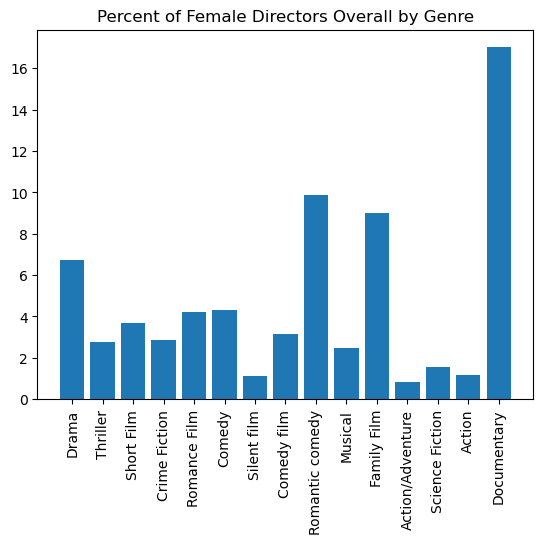

In [231]:
plt.bar(genres_group.head(15).index, genres_group.fperc_dirs.head(15))
plt.xticks(rotation=90)
plt.title('Percent of Female Directors Overall by Genre')
None

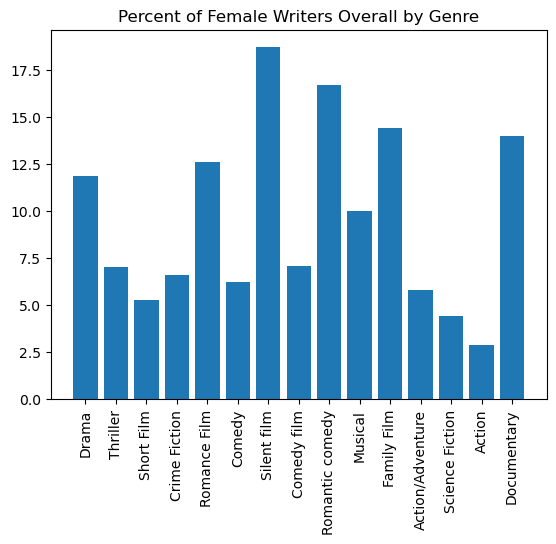

In [232]:
plt.bar(genres_group.head(15).index, genres_group.fperc_wris.head(15))
plt.xticks(rotation=90)
plt.title('Percent of Female Writers Overall by Genre')
None

It can be seen that in general there are a higher percentage of female writers in the top 15 genres than there are female directors. Next to look at is the percent of females on the creative team by genre. This will require the full_crew dataset to undergo the genre processing like the previous dataset.

In [233]:
genre_movie_groups_temp = full_crew.copy()
genre_movie_groups_temp['genre_1'] = genre_movie_groups_temp.genres.apply(lambda x: x[0] if len(x)>0 else np.nan)
genre_movie_groups_temp['genre_2'] = genre_movie_groups_temp.genres.apply(lambda x: x[1] if len(x)>1 else np.nan)
genre_movie_groups_temp['genre_3'] = genre_movie_groups_temp.genres.apply(lambda x: x[2] if len(x)>2 else np.nan)

genre_movie_groups_temp.head()


,title,release_year,runtime,rating,num_votes,genres,movie_freebase_id,movie_imdb_id,imdb_id,role,...,normal_rating,abs_normal_rating,log_num_votes,normal_log_num_votes,impact_score,impact_score_2,genre_1,all_crew,genre_2,genre_3
2,Brun bitter,1988.0,83.0,5.7,40.0,"[Crime Fiction, Drama]",/m/0crgdbh,tt0094806,nm0803751,director,...,-0.522734,0.522734,3.688879,-1.244823,-0.650711,-0.477276,Crime Fiction,True,Drama,NaN
9,City of the Dead,1960.0,76.0,6.7,7597.0,"[Horror, Supernatural]",/m/075f66,tt0053719,nm0610303,director,...,0.347575,0.347575,8.935509,1.058862,0.368034,1.118053,Horror,True,Supernatural,NaN
12,Little city,1997.0,93.0,5.8,1111.0,"[Romantic comedy, Ensemble Film, Comedy-drama,...",/m/0gffwj,tt0119548,nm0070142,director,...,-0.435703,0.435703,7.013016,0.214735,0.093561,-1.033747,Romantic comedy,True,Ensemble Film,Comedy-drama
21,The Devil's Holiday,1930.0,80.0,6.0,213.0,"[Romance Film, Drama, Black-and-white]",/m/017n1b,tt0020823,nm0332539,director,...,-0.261641,0.261641,5.361292,-0.510502,-0.133568,-0.431017,Romance Film,True,Drama,Black-and-white
24,Freddy and the Song of the South Pacific,1962.0,97.0,5.4,49.0,"[Drama, Adventure]",/m/0h964n1,tt0055997,nm0414672,director,...,-0.783826,0.783826,3.891820,-1.155716,-0.905881,-0.785509,Drama,True,Adventure,NaN


In [234]:
genre_movie = pd.DataFrame()
genre_movie = pd.merge(left=year_by_fperc, right=genre_movie_groups_temp[['movie_freebase_id', 'genre_1']], 
                                how='left', on='movie_freebase_id')
genre_movie_groups = genre_movie.drop_duplicates(keep='first').groupby('genre_1')

Text(0, 0.5, 'Percent Female')

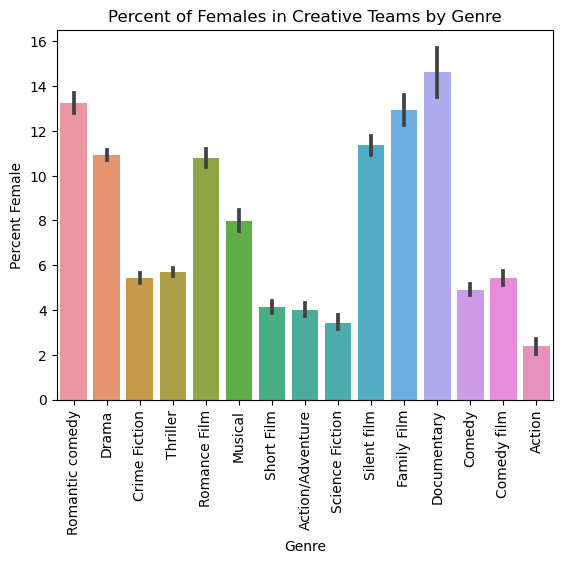

In [235]:
sns.barplot(data=genre_movie[genre_movie.genre_1.isin(top_genres)][['genre_1', 'percent_female']],
    x='genre_1', y='percent_female')
plt.xticks(rotation=90)
plt.title('Percent of Females in Creative Teams by Genre')
plt.xlabel('Genre')
plt.ylabel('Percent Female')

Text(0, 0.5, 'IMDB Rating')

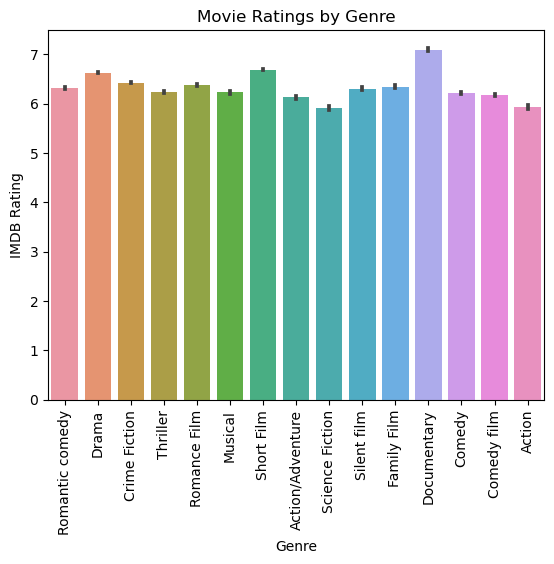

In [236]:
sns.barplot(data=genre_movie[genre_movie.genre_1.isin(top_genres)][['genre_1', 'rating']],
    x='genre_1', y='rating')
plt.xticks(rotation=90)
plt.title('Movie Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')

#### Directors and Writers in the Top 1000 Movies <a id='top-100'></a>

We have seen the trends in movies as a whole, but are there any hidden trends in the movies with the highest ratings? We can start by looking into what the top 1000 movies look like in terms of their data

In [237]:
top_movies = full_crew[['movie_freebase_id', 'rating']].groupby('movie_freebase_id').rating.agg('mean')
top_movies.sort_values(ascending=False, inplace=True)
top_movies_indx = top_movies.head(1000).index
top_movies_df = full_crew[full_crew.movie_freebase_id.isin(top_movies_indx)]
top_movies_grouped_temp = pd.DataFrame()
top_movies_grouped_temp['percent_female'] = top_movies_df.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))
top_movies_grouped= pd.merge(left=top_movies_grouped_temp,
        right= top_movies_df[['movie_freebase_id', 'rating', 'runtime', 'release_year', 'genres']],
        how='left', left_index=True, right_on='movie_freebase_id')

top_movies_grouped['genre_1'] = top_movies_grouped.genres.apply(lambda x: x[0] if len(x)>1 else np.nan)

top_movies_grouped.head()


,percent_female,movie_freebase_id,rating,runtime,release_year,genres,genre_1
19434,0.0,/m/011_mj,8.1,68.0,1928.0,"[Romantic comedy, Silent film, Adventure, Blac...",Romantic comedy
122442,0.0,/m/011_mj,8.1,68.0,1928.0,"[Romantic comedy, Silent film, Adventure, Blac...",Romantic comedy
68686,0.0,/m/011x_4,8.1,101.0,1993.0,"[Romantic comedy, Drama, Comedy, Fantasy, Time...",Romantic comedy
217137,0.0,/m/011x_4,8.1,101.0,1993.0,"[Romantic comedy, Drama, Comedy, Fantasy, Time...",Romantic comedy
217138,0.0,/m/011x_4,8.1,101.0,1993.0,"[Romantic comedy, Drama, Comedy, Fantasy, Time...",Romantic comedy


Text(0.5, 1.0, 'Number of Top Movies in Genres')

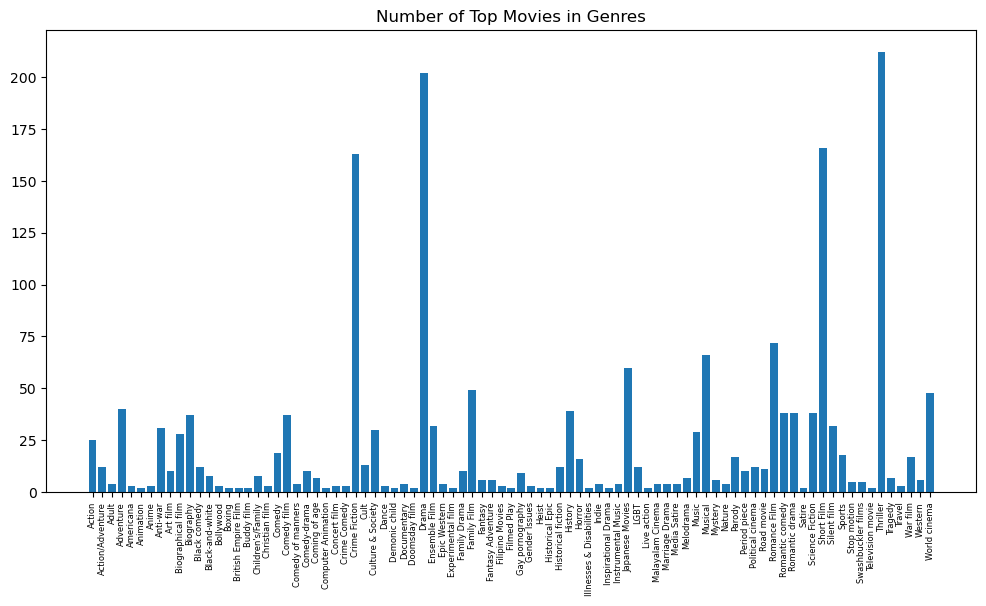

In [238]:
plt.figure(figsize=(12,6))
plt.bar(top_movies_grouped.groupby('genre_1').groups.keys(), top_movies_grouped.groupby('genre_1').movie_freebase_id.agg('count'))
plt.xticks(rotation=90, fontsize=6)
plt.title('Number of Top Movies in Genres')

Text(0.5, 1.0, 'Percent Female on the Creative Team')

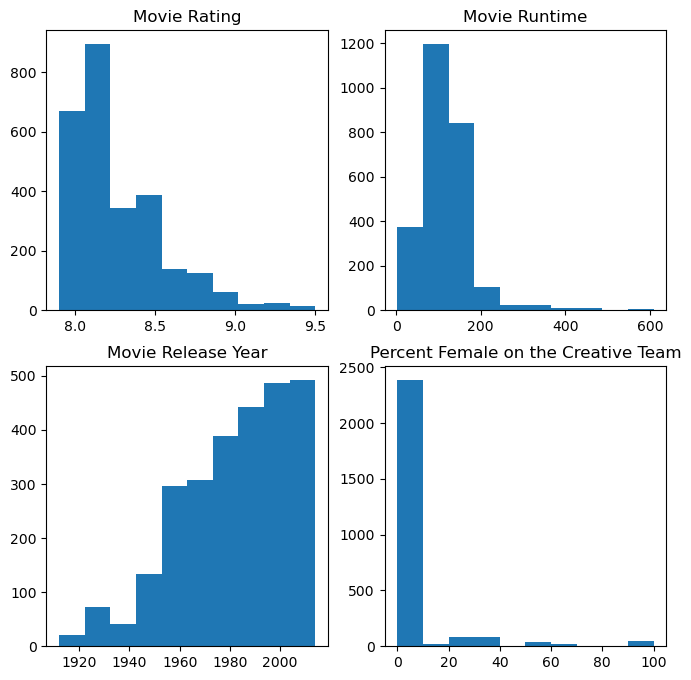

In [239]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].hist(top_movies_grouped.rating)
ax[0,0].set_title('Movie Rating')
ax[0,1].hist(top_movies_grouped.runtime)
ax[0,1].set_title('Movie Runtime')
ax[1,0].hist(top_movies_grouped.release_year)
ax[1,0].set_title('Movie Release Year')
ax[1,1].hist(top_movies_grouped.percent_female)
ax[1,1].set_title('Percent Female on the Creative Team')

Now we can look at at the make up of directors and writers in these top 1000 movies in terms of gender.

In [240]:
male_dir_top = top_movies_df.loc[(top_movies_df.gender == 'male') & (top_movies_df.role == 'director')]
female_dir_top = top_movies_df.loc[(top_movies_df.gender == 'female') & (top_movies_df.role == 'director')]
male_wri_top = top_movies_df.loc[(top_movies_df.gender == 'male') & (top_movies_df.role == 'writer')]
female_wri_top = top_movies_df.loc[(top_movies_df.gender == 'female') & (top_movies_df.role == 'writer')]

print(f'Out of the top 1000 Movies there are {len(male_dir_top)} male directors and {len(female_dir_top)} female directors.')
print(f'{male_dir_top.imdb_id.nunique()} of those male directors are unique and {female_dir_top.imdb_id.nunique()} of those female directors are unique.')
print()
print(f'Out of the top 1000 Movies there are {len(male_wri_top)} male writers and {len(female_wri_top)} female writers.')
print(f'{male_wri_top.imdb_id.nunique()} of those male writers are unique and {female_wri_top.imdb_id.nunique()} of those female writers are unique.')

Out of the top 1000 Movies there are 1029 male directors and 40 female directors.
751 of those male directors are unique and 38 of those female directors are unique.

Out of the top 1000 Movies there are 1526 male writers and 87 female writers.
1110 of those male writers are unique and 79 of those female writers are unique.


#### New Metric for Movie Ratings

Now that we have decided a new metric for to measure the data we can create that for our datasheet and then rerun the analysis

First a review of the Dataframes that we may want to use again

director_movies - Base dataframe with all merged data <br>
dirs – all directors values <br>
writers – all writers values<br>
uniq_dirs – all uniq director values<br>
uniq_wris – all unique writer values<br>
full_dirs – unique directors with gender, name, and birth data<br>
full_wris – unique writers with gender, name, and birth data<br>
full_crew – movies that have director and writer data that all has at least a male or female gender<br>
male_dir – male directors<br>
male_writer – male writers<br>
female_dir – female directors<br>
female_writer – female writers<br>
rating_by_fperc – dataframe with each movie ID containing info of percent_female and rating, <br>
year_by_fperc – dataframe with each movie ID containing info of percent female and release year<br>
year_by_fperc_avg – Dataframe with year_by_fperc data but averaged over each release year<br>
genres_df – this dataframe is a copy of the directors_movies dataframe, but the genres are now divided up as genre_1, genre_2, and genre_3<br>
genres_group – dataframe with the data from genres_df but grouped by genre_1


The first goal will be to determine the impact of movies based on the female crew percent for this we can create a dataframe with the impact score by fpercent

In [241]:
directors_movies.impact_score.describe()

count    234845.000000
mean          0.021948
std           1.018067
min          -8.500313
25%          -0.347265
50%          -0.007057
75%           0.329393
max           9.473819
Name: impact_score, dtype: float64

In [242]:
impact_score_by_fperc = pd.DataFrame()
impact_score_by_fperc['percent_female'] = full_crew.groupby('movie_freebase_id').apply(
    lambda x: 100*round(len(x[x.gender == 'female'])/len(x),4))

impact_score_by_fperc['impact_score'] = full_crew.groupby('movie_freebase_id').impact_score.unique()
print(f'Is there only one unique impact_score value per movie? {all(impact_score_by_fperc.impact_score.apply(lambda x: len(x)) == 1)}')
impact_score_by_fperc['impact_score'] = impact_score_by_fperc['impact_score'].apply(lambda x: x[0])
impact_score_by_fperc['release_year'] = full_crew.groupby('movie_freebase_id').release_year.unique()
print(f'Is there only one unique release_year value per movie? {all(impact_score_by_fperc.release_year.apply(lambda x: len(x)) == 1)}')
impact_score_by_fperc['release_year'] = impact_score_by_fperc['release_year'].apply(lambda x: x[0])
impact_score_by_fperc.head()

Is there only one unique impact_score value per movie? True
Is there only one unique release_year value per movie? True


,percent_female,impact_score,release_year
movie_freebase_id,,,
/m/011_mj,0.0,2.686725,1928.0
/m/011x_4,0.0,4.692854,1993.0
/m/011xg5,0.0,2.100958,2001.0
/m/011xrr,0.0,0.141074,1984.0
/m/011ycb,0.0,2.122550,1994.0


Text(0.5, 0, 'Percentage of Females on Writing Team')

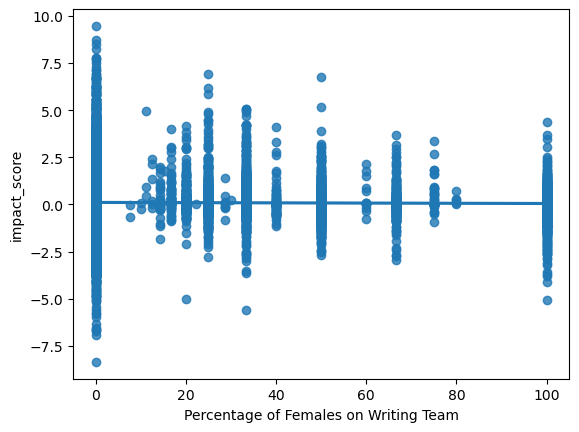

In [243]:
sns.regplot(data=impact_score_by_fperc, x='percent_female', y='impact_score')
plt.xlabel('Percentage of Females on Writing Team')

Text(0.5, 1.0, 'Average Movie impact_scores Compared to Percent of Females on Creative Team')

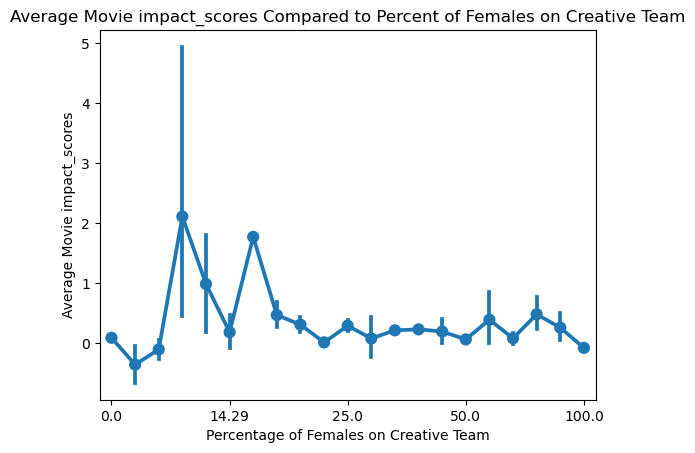

In [244]:
sns.pointplot(data=impact_score_by_fperc, x='percent_female', y='impact_score', errorbar=('ci', 95))
plt.xticks([0,5,10,15, 20])
plt.xlabel('Percentage of Females on Creative Team')
plt.ylabel('Average Movie impact_scores')
plt.title('Average Movie impact_scores Compared to Percent of Females on Creative Team')


We can try creating two linear regression models, the first can be based off of a movie and information surrounding the director and average crew data, the other one could be linked to the people themselves.

In [245]:
print(full_crew.columns)

Index(['title', 'release_year', 'runtime', 'rating', 'num_votes', 'genres',
       'movie_freebase_id', 'movie_imdb_id', 'imdb_id', 'role', 'name',
       'gender', 'birth', 'height', 'ethnicity', 'birth_year',
       'age_at_release', 'normal_rating', 'abs_normal_rating', 'log_num_votes',
       'normal_log_num_votes', 'impact_score', 'impact_score_2', 'genre_1',
       'all_crew'],
      dtype='object')


In [246]:
movie_reg = pd.DataFrame()
full_crew_grouped = full_crew.groupby('movie_freebase_id')
director_grouped = full_crew.loc[full_crew.role == 'director'].groupby('movie_freebase_id')
writer_grouped = full_crew.loc[full_crew.role == 'writer'].groupby('movie_freebase_id')
movie_reg['impact_score'] = full_crew_grouped.impact_score.unique()
if all(movie_reg.impact_score.apply(lambda x: len(x)) == 1):
    movie_reg['impact_score'] = movie_reg.impact_score.apply(lambda x: x[0])
movie_reg['director_fperc'] = director_grouped.apply(
    lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
movie_reg['writer_fperc'] = writer_grouped.apply(
    lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
movie_reg['director_male'] = movie_reg.director_fperc.apply(lambda x: 1 if x==0 else 0)
movie_reg['director_female'] = movie_reg.director_fperc.apply(lambda x: 1 if x==1 else 0)
movie_reg['full_male'] = movie_reg.apply(lambda x: 1 if x.director_fperc == 0 and x.writer_fperc == 0 else 0, axis=1)
movie_reg['full_female'] = movie_reg.apply(lambda x: 1 if x.director_fperc == 1 and x.writer_fperc == 1 else 0, axis=1)
print(f'The length of the original dataset is {len(directors_movies)}, the full crew length is {len(full_crew)}, the length of the final dataset is {len(movie_reg)}')

movie_reg

The length of the original dataset is 250745, the full crew length is 74786, the length of the final dataset is 27382


,impact_score,director_fperc,writer_fperc,director_male,director_female,full_male,full_female
movie_freebase_id,,,,,,,
/m/011_mj,2.686725,0.0,0.0,1,0,1,0
/m/011x_4,4.692854,0.0,0.0,1,0,1,0
/m/011xg5,2.100958,0.0,0.0,1,0,1,0
/m/011xrr,0.141074,0.0,0.0,1,0,1,0
/m/011ycb,2.122550,0.0,0.0,1,0,1,0
...,...,...,...,...,...,...,...
/m/0yxm1,1.369153,0.0,0.0,1,0,1,0
/m/0yyg4,2.864779,0.0,0.0,1,0,1,0
/m/0yyn5,0.847551,0.0,0.0,1,0,1,0


In [247]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [248]:
train, test = split_set(movie_reg.dropna())

train_features = train[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
train_y = train['impact_score']
test_features = train[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
test_y = train['impact_score']

In [249]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_features,train_y)

LinearRegression()

In [250]:
print(model.intercept_, model.coef_, model.score(train_features, train_y))

0.7259869498126285 [-1.38377424 -0.17923285 -0.38956072  0.78835531 -0.24761146 -0.02679241] 0.00326516226588347


In [251]:
import statsmodels.api as sm

x = sm.add_constant(train_features)
model_2 = sm.OLS(train_y, x).fit()

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.28
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.30e-12
Time:                        17:31:54   Log-Likelihood:                -29677.
No. Observations:               20659   AIC:                         5.937e+04
Df Residuals:                   20652   BIC:                         5.942e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7260      0.631     

so it looks like regardless of what we do it isn't giving us a model that can fit the data. Let's take a look at genres instead for now. the first thing to do would be to either look at the best genres or the most abundant genres, I think we can look at abundance first

In [292]:
genre_amounts = full_crew.groupby('genre_1').genre_1.apply('count')
genres_considered = genre_amounts.sort_values(ascending=False).head(50).index.tolist()
genres_considered


['Drama',
 'Thriller',
 'Short Film',
 'Crime Fiction',
 'Comedy',
 'Romantic comedy',
 'Romance Film',
 'Silent film',
 'Comedy film',
 'Musical',
 'Action/Adventure',
 'Romantic drama',
 'Family Film',
 'Science Fiction',
 'LGBT',
 'Horror',
 'Japanese Movies',
 'Parody',
 'Action',
 'Black-and-white',
 'Documentary',
 'Western',
 'Adventure',
 'World cinema',
 'Sports',
 'Mystery',
 'Biography',
 'History',
 'Indie',
 'Biographical film',
 'Cult',
 'Black comedy',
 'Period piece',
 'Family Drama',
 'Culture & Society',
 'Ensemble Film',
 'Fantasy',
 'Music',
 'Comedy-drama',
 'Melodrama',
 'War film',
 'Historical fiction',
 'Christian film',
 'Political cinema',
 'Monster movie',
 "Children's/Family",
 'Zombie Film',
 'Animation',
 'Buddy film',
 'Sex comedy']

In [293]:
R2 = []

for genre in genres_considered:
    genre_df = full_crew.loc[full_crew.genre_1 == genre].drop(['normal_rating', 'abs_normal_rating',
        'log_num_votes', 'normal_log_num_votes', 'impact_score', 'impact_score_2'], axis=1
    )
    mean_ratings = genre_df.rating.mean()
    std_ratings = genre_df.rating.std()
    genre_df['normal_rating'] = (genre_df.rating-mean_ratings)/std_ratings
    genre_df['abs_normal_rating'] = abs(genre_df.normal_rating)

    genre_df['log_num_votes'] = np.log(genre_df.num_votes)
    mean_log_votes = genre_df.log_num_votes.mean()
    std_log_votes = genre_df.log_num_votes.std()
    genre_df['normal_log_num_votes'] = (genre_df.log_num_votes - mean_log_votes)/std_log_votes
    min_norm_log_num_votes = genre_df.normal_log_num_votes.min()

    genre_df['impact_score'] = (genre_df.normal_log_num_votes) * genre_df.abs_normal_rating

    df = pd.DataFrame()
    genre_df_grouped = genre_df.groupby('movie_freebase_id')
    director_grouped = genre_df.loc[genre_df.role == 'director'].groupby('movie_freebase_id')
    writer_grouped = genre_df.loc[genre_df.role == 'writer'].groupby('movie_freebase_id')

    df['impact_score'] = genre_df_grouped.impact_score.unique()
    if all(df.impact_score.apply(lambda x: len(x)) == 1):
        df['impact_score'] = df.impact_score.apply(lambda x: x[0])
    df['director_fperc'] = director_grouped.apply(
        lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
    df['writer_fperc'] = writer_grouped.apply(
        lambda x: round(len(x[x.gender == 'female'])/len(x),4)) #This is because there are movies with several directors
    df['director_male'] = df.director_fperc.apply(lambda x: 1 if x==0 else 0)
    df['director_female'] = df.director_fperc.apply(lambda x: 1 if x==1 else 0)
    df['full_male'] = df.apply(lambda x: 1 if x.director_fperc == 0 and x.writer_fperc == 0 else 0, axis=1)
    df['full_female'] = df.apply(lambda x: 1 if x.director_fperc == 1 and x.writer_fperc == 1 else 0, axis=1)
    df.dropna(inplace=True)

    features = df[['director_fperc', 'writer_fperc', 'director_male', 'director_female', 'full_male', 'full_female']]
    y = df['impact_score']

    x = sm.add_constant(features)
    model_2 = sm.OLS(y, x).fit()
    print(genre)
    print(model_2.summary())
    print()
    row={
        'genre':genre,
        'r2':model_2.rsquared,
        'movies':len(df)
    }
    R2.append(row)
    
    

Drama
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.956
Date:                Thu, 08 Dec 2022   Prob (F-statistic):             0.0684
Time:                        18:27:22   Log-Likelihood:                -6189.3
No. Observations:                4008   AIC:                         1.239e+04
Df Residuals:                    4001   BIC:                         1.244e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0042      1.91

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


Documentary
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.858
Date:                Thu, 08 Dec 2022   Prob (F-statistic):            0.00988
Time:                        18:27:35   Log-Likelihood:                -525.08
No. Observations:                 369   AIC:                             1064.
Df Residuals:                     362   BIC:                             1092.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4127    

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


Adventure
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.790
Date:                Thu, 08 Dec 2022   Prob (F-statistic):              0.132
Time:                        18:27:36   Log-Likelihood:                -378.19
No. Observations:                 239   AIC:                             766.4
Df Residuals:                     234   BIC:                             783.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2399      

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


Black comedy
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.465
Date:                Thu, 08 Dec 2022   Prob (F-statistic):             0.0355
Time:                        18:27:37   Log-Likelihood:                -203.71
No. Observations:                 150   AIC:                             419.4
Df Residuals:                     144   BIC:                             437.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.5166   

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


Monster movie
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.3609
Date:                Thu, 08 Dec 2022   Prob (F-statistic):              0.781
Time:                        18:27:39   Log-Likelihood:                -94.956
No. Observations:                  59   AIC:                             197.9
Df Residuals:                      55   BIC:                             206.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1227  

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


Animation
                            OLS Regression Results                            
Dep. Variable:           impact_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.090
Method:                 Least Squares   F-statistic:                  0.008827
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               1.00
Time:                        18:27:40   Log-Likelihood:                -69.520
No. Observations:                  49   AIC:                             149.0
Df Residuals:                      44   BIC:                             158.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6327      

c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\aliwa\anaconda3\envs\ada\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [296]:
genre_regg = pd.DataFrame(R2)
genre_regg.sort_values('r2', ascending=False)

,genre,r2,movies
45,Children's/Family,0.143358,48
43,Political cinema,0.093106,66
27,History,0.082244,154
31,Black comedy,0.078841,150
25,Mystery,0.073568,180
42,Christian film,0.060567,62
12,Family Film,0.054894,433
38,Comedy-drama,0.053286,106
20,Documentary,0.045220,369
15,Horror,0.043283,453
